# Import Statements

In [98]:
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/catharinewu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import OCR_pipeline as OCR
import TopicModeling as TM
import jsonpickle

# Cleaning And Saving Extracted Text

In [101]:
import mysql.connector

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="seagull12",
  database="forestry"
)
mycursor = mydb.cursor()

def getExtractedTexts():
    mycursor.execute("SELECT filename, pid, text from PolicyPaperPages " \
                     "GROUP BY filename, pid ORDER BY filename, pid")

    myresult = mycursor.fetchall()
    
    return combinePages(myresult)

def combinePages(myresult):
    curr_filename = okay[0][0]
    curr_pages = []

    file_texts = []
    for result in okay:
        if result[0] != curr_filename:
            file_texts.append((curr_filename, ' '.join(curr_pages)))
            curr_pages = []
            curr_filename = result[0]
        else:
            curr_pages.append(result[2])

    file_texts.append((result[0], ' '.join(curr_pages)))
    return file_texts

def getExtractedTexts():
    mycursor.execute("SELECT filename, extractedText FROM PolicyPapers")
    myresult = mycursor.fetchall()
    return [x for x in myresult]

def getExtractedTextsFromCountries(countries):
    sqlStatement = "SELECT filename, extractedText FROM PolicyPapers WHERE"
    
    for i in range(len(countries)):
        whereClause = " country = '%s' " % countries[i]
        sqlStatement += whereClause
        if len(countries) != 1 and i < len(countries) - 1:
            sqlStatement += "or"
            
    mycursor.execute(sqlStatement)
    myresult = mycursor.fetchall()
    return [x for x in myresult]

In [102]:
key_words = ['afforestation','agriculture','animal welfare','artificial regeneration','biodiversity',
             'biological resources','biome','board','clean','coconut','conservation','control','database',
             'enforcement','environment','farm','financing','forest','forest protection','funding','fundraising',
             'land ','land use','landholder','law','measuring','mobilization','monitor','natural resources',
             'oversight','plant breeders','plants','pollution','preservation','produce','protection','qualification',
             'quality','registry','regulation','reporting','reserve','resource','restriction','results-driven',
             'rural','safeguard','species' ,'support','sustainable','technical submission','threatened species',
             'variety','verification','wastewater','water','watershed','wild life']

In [103]:
spanish_key_words = ['repoblación forestal', 'agricultura', 'bienestar de los animales', 'regeneración artificial', 
                     'biodiversidad', 'recursos biologicos', 'bioma', 'tablero', 'limpiar', 'Coco', 'conservación',
                     'controlar', 'base de datos', 'aplicación', 'ambiente', 'granja', 'financiación', 'bosque', 
                     'protección forestal', 'fondos', 'recaudación de fondos', 'tierra', 'uso del suelo', 
                     'terrateniente', 'ley', 'medición', 'movilización', 'monitor', 'recursos naturales', 'vigilancia',
                     'fitomejoradores', 'plantas', 'contaminación', 'preservación', 'Produce', 'proteccion',
                     'calificación', 'calidad', 'registro', 'regulación', 'reportando', 'reserva', 'recurso', 
                     'restricción', 'impulsado por resultados', 'rural', 'salvaguardia', 'especies', 'apoyo', 
                     'sostenible', 'sumisión técnica', 'especies amenazadas', 'variedad', 'verificación', 
                     'aguas residuales', 'agua', 'cuenca', 'fauna silvestre']

In [104]:
#dictionary for texts in terms of sentences
import re
import gc
textDictionary = {}
countries = ['India']
policyPapers = getExtractedTextsFromCountries(countries)
language_keywords = {}
language_keywords['english'] = key_words
language_keywords['spanish'] = spanish_key_words
for paper in policyPapers:
    cleanWhitespaces = re.sub(r'(.) ', r'\1', paper[1])
    cleanedText = TM.toSentences(cleanWhitespaces, 'english', language_keywords['english'])
    textDictionary[paper[0]] = cleanedText

# LDA

In [105]:
from pprint import pprint
lemmatized_sents = []

# Print the Keywords in the 5 topics
for key in textDictionary:
    cleanedText = textDictionary[key]
    lemmatized_sents.extend(cleanedText)
    
corpus, lda_model = TM.LDA(lemmatized_sents)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
#Next Step: Store LDA data in Policy Paper Object & other central file

[(10,
  '0.042*"forest" + 0.025*"damage" + 0.016*"timber" + 0.014*"land" + '
  '0.013*"officer" + 0.013*"tree" + 0.012*"loss" + 0.011*"mark" + '
  '0.011*"depot" + 0.010*"shall"'),
 (6,
  '0.033*"water" + 0.012*"wild" + 0.012*"animal" + 0.011*"hunt" + '
  '0.008*"cause" + 0.007*"include" + 0.007*"mean" + 0.007*"activity" + '
  '0.007*"degradation" + 0.006*"affect"'),
 (13,
  '0.037*"mineral" + 0.026*"state" + 0.014*"quantity" + 0.013*"annual" + '
  '0.013*"government" + 0.012*"year" + 0.011*"land" + 0.011*"part" + '
  '0.011*"shall" + 0.010*"ore"'),
 (19,
  '0.026*"name" + 0.025*"mineral" + 0.024*"mine" + 0.023*"mining" + '
  '0.022*"coconut" + 0.019*"controller" + 0.018*"mean" + 0.015*"agent" + '
  '0.014*"owner" + 0.014*"rule"'),
 (27,
  '0.035*"monitor" + 0.017*"need" + 0.013*"regulation" + 0.012*"forest" + '
  '0.010*"medium" + 0.009*"regulatory" + 0.009*"use" + 0.009*"moud" + '
  '0.008*"service" + 0.008*"burden"'),
 (23,
  '0.052*"section" + 0.038*"sub" + 0.027*"shall" + 0.018*"m

In [106]:
my = lda_model.print_topics()[0][1]

In [107]:
re.findall(r"[a-zA-Z]+",my)

['forest',
 'damage',
 'timber',
 'land',
 'officer',
 'tree',
 'loss',
 'mark',
 'depot',
 'shall']

## Extract sentences by Keywords

### TODO: Have a feature on the web app so that the user can extract text using keywords

In [108]:
#Try with the first document
policy_0 = policyPapers[0][1]
sentences = TM.ReturnSentence(policy_0)

In [109]:
#This can be used as a preview feature
for s in sentences:
    if 'land' in s:
        print(s)

 (2) Notwithstanding anything contained in sub-rule (1) a scheme of prospecting, shall include: (a) baseline information of prevailing environmental conditions before the beginning of prospecting operations; (b) [steps proposed to be taken for protection of environment which will include] prevention and control of air and water pollution, progressive reclamation and rehabilitation of the land disturbed by the prospecting operations, a scheme for the plantation of trees, and such other measures, as may be directed from time to time by the Controller General or the authorised officer for minimising the adverse effect of prospecting operations on the environment
 Types of plans and sections: (1) The owner, agent, mining engineer or manager of every mine shall keep the following plans and sections(a) a surface plan showing every surface feature within the mining lease boundaries, such as building, telephone, telegraph or power transmission line, watermain, tramline, railway, road, river, w

## Use Key Words to classify documents

In [110]:
key_words = ['afforestation','agriculture','animal welfare','artificial regeneration','biodiversity',
             'biological resources','biome','board','clean','coconut','conservation','control','database',
             'enforcement','environment','farm','financing','forest','forest protection','funding','fundraising',
             'land ','land use','landholder','law','measuring','mobilization','monitor','natural resources',
             'oversight','plant breeders','plants','pollution','preservation','produce','protection','qualification',
             'quality','registry','regulation','reporting','reserve','resource','restriction','results-driven',
             'rural','safeguard','species' ,'support','sustainable','technical submission','threatened species',
             'variety','verification','wastewater','water','watershed','wild life']

In [111]:
'artificial regeneration' in cleanWhitespaces

False

# Visualizations

### pyLDAvis

`pip install pyldavis`

Code source: https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html
<br>
The area of the circles represent the prevalance of the topic. The length of the bars on the right represent the membership of a term in a particular topic. 

In [112]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
# p = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
# pyLDAvis.save_html(p, 'pyLDAvis.html')

### WordCloud

`pip install wordcloud`

Code source: https://medium.com/@rudyb2001/making-sense-of-the-news-using-machine-learning-e13ed5f96cf0
<br>
WordCloud of Top 10 words in each topic with the sizes of the words proportional to the weights.

In [113]:
len(lda_model.show_topics(formatted=False))

10

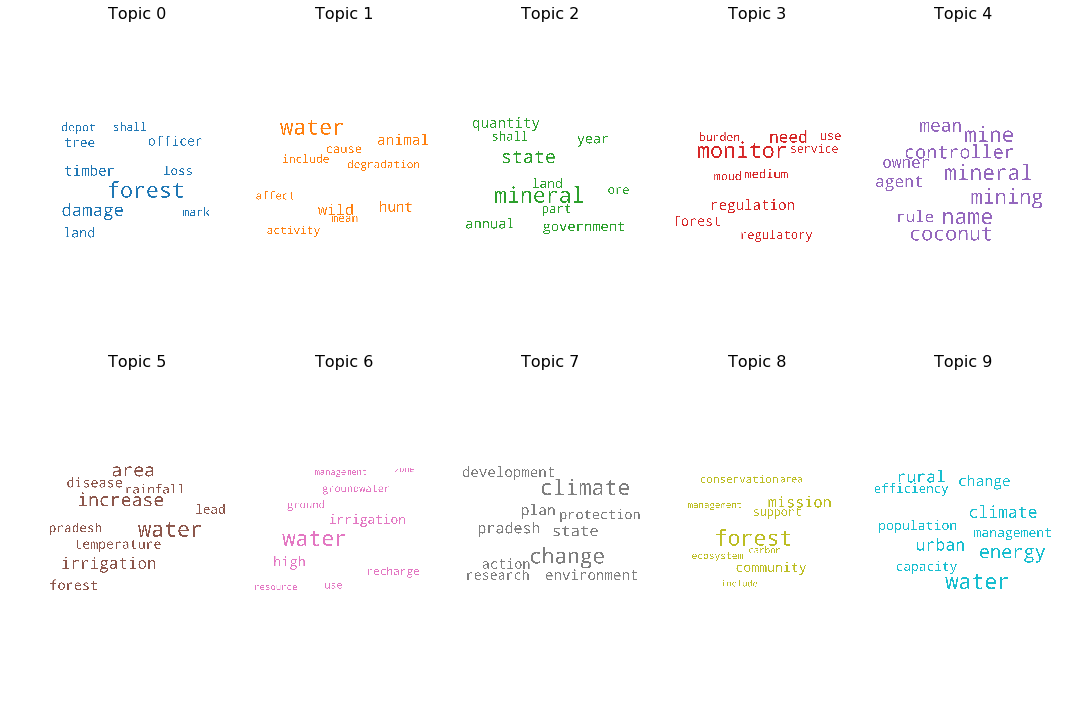

In [114]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Storage